# Verification of terminal digits test

Verification of the terminal digits test.
In this case the three colony counts are considered independent
extrations.
The hypotesis is that the last digit of each count can be modeled
as a draw from a uniform distribution.

DELETEME: (This version uses the same data import of the other tests - pandas...)

In [70]:
# import numpy and matlab plot library

from __future__ import print_function
import numpy as np

%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt


import scipy
import scipy.stats as stats

# import panda
import pandas as pd

In [72]:
#DELETEME - only one needed in the final notebook
## List of Functions

# This function takes an N by 3 matrix, sorts the matrix row wise, and then computes the ratio of (mid-min)/(max-min)
# for each row (excludes the rows with all equal entries.)
def compute_ratio(M):
    M.sort(axis=1)
    if (M.shape[1]!=3):
        print('Size is flawed ')
        print(M.shape)
        
    mid_min = M[:, 1] - M[:, 0]
    max_min = M[:, 2] - M[:, 0]
    ratio = ([mid_min[t]/max_min[t] for t in range(max_min.shape[0]) if max_min[t] !=0 ])
    return np.asarray(ratio)

# This function returns a list of last digits for an np array/ndarray input, and ignores the NAN values
def compute_last_digit(n_arr):
    n_arr = n_arr.flatten()
    return np.asarray([int (n%10) for n in n_arr if not(np.isnan(n))])

# This function returns a list of last two digits for an np array/ndarray input 
# only for samples with more than 3 digits, 
# and ignores the NAN values.
# Saves it as a string
def compute_last_two_digits(n_arr):
    n_arr = n_arr.flatten()
    return ['%02d'%int(n%100) for n in n_arr if not(np.isnan(n)) and n > 99]

# This function takes a list of strings representing the last two digits and builds a simple 1-0 list 
# representing the equality of the last two digits:
# out[i] = 1 if n_list[i] has equal digits, 0 otherwise
def compute_last_two_digits_binary(n_list):
    return [1 if n[0]==n[1] else 0 for n in n_list]

# This function simply plots a histogram of the data (named ratio) with a given title and displays it inline.
def plot_np_hist(ratio, s='Title', show=False):
    plt.hist(ratio, bins=10, normed = False)
    plt.title(s)
    if show:
        plt.show()

# The next two functions are for obtaining histograms that look similar to the ones given in the paper. In these versions
# since we have to include the right hand edge, I do it manually - both the computation and the plotting of the bars.
def compute_my_histogram(ratio):
    v = np.zeros(10)
    N = len(ratio)
    v[0] = np.sum([( x <= 0.1) for x in ratio])
    for i in range(2, 11):
        thr = float(i) /10.
        v[i-1] = np.sum([( x <= thr and x > thr-0.1) for x in ratio])
    v /= np.sum(v)
    return v
def plot_my_histogram(v, s='Title', show=False):
    x = np.linspace(0,1,10,endpoint=False)
    plt.bar(x, v, width=0.1)
    plt.title(s)
    if show:
        plt.show()

In [42]:
# Permutation Test Set Ups : We use three different test statistics, namely difference in std deviation, l1-distance
# between the two densities, and l1-distance between the two CDFs.

# Compute the difference between std deviation of two datasets
def std_diff(v1, v2):
    return np.abs(np.std(v1)-np.std(v2))

# Computes the l1 distance between empirical densities of two datasets by computing normalized empirical histogram
def density_distance(v1, v2):
    counts1, _ = np.histogram(v1, bins=10, density=True)
    counts1 /= np.sum(counts1)
    counts2, _ = np.histogram(v2, bins=10, density=True)
    counts2 /= np.sum(counts2)
    return np.sum(np.abs(counts1-counts2))

# Computes the l1 distance between empirical CDFs of two datasets by computing normalized empirical histogram
def cdf_distance(v1, v2):
    counts1, _ = np.histogram(v1, bins=10, density=True)
    counts1 /= np.sum(counts1)
    c1 = np.cumsum(counts1)
    counts2, _ = np.histogram(v2, bins=10, density=True)
    counts2 /= np.sum(counts2)
    c2 = np.cumsum(counts2)
    return np.sum(np.abs(c1-c2))

# Performs permutation test by treating xs as the treatment group, and ys as the control group, the local variable zs
# denote the pooled data, and random.shuffle is used to create bootstrapped version of treatment and control groups.
# The function returns the p-value, test-statistic, and all the simulated random values of the test-statistic which 
# are later used to plot histograms for visualization of data by naked eye.
def exact_mc_perm_test(xs, ys, nmc, test_fun=std_diff):
    n, k = len(xs), 0
    diff = test_fun(xs, ys)
    zs = np.concatenate([xs, ys])
    ts = np.zeros(nmc)
    for j in range(nmc):
        np.random.shuffle(zs)
        ts[j] = test_fun(zs[:n],zs[n:])
        k += diff < ts[j]
    return float(k)/nmc , diff, ts

# This function simply reduces the culttering of ticks on x and y axis for clarity.
def pretty_plots(ax, v, name):
    max_yticks = 5
    max_xticks = 5
    plot_np_hist(v, name)
    yloc = plt.MaxNLocator(max_yticks)
    xloc = plt.MaxNLocator(max_xticks)
    ax.yaxis.set_major_locator(yloc)
    ax.xaxis.set_major_locator(xloc)
    
nmc = 1000

In [73]:
# Load the datasets, with the investigator label for the data of the other labmates.

rts_colony_df = pd.read_excel("data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx", 
                              na_values = [' '], skiprows=[0,1], parse_cols = ("D:F"), header = 0)   

rest_colony_df = pd.read_excel("data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx", 
                               na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:F"))

out3_colony_df = pd.read_excel("data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("B:D"))

rts_coulter_df = pd.read_excel("data/Bishayee Coulter Counts.10.20.97-7.16.01.xlsx", 
                               na_values = [' '], skiprows=[0], parse_cols = ("C:E"), header = 0)   

rest_coulter_df = pd.read_excel("data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:E,G"))

out1_coulter_df = pd.read_excel("data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.xlsx", 
                                na_values = [' '], header = None, skiprows = [0], parse_cols = ("B:D"))

out2_coulter_df = pd.read_excel("data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("B:D"))



In [75]:
print(rts_colony_df.values[0:3,:])
print(rest_colony_df.values[0:3,:])
print(out3_colony_df.values[0:3,:])
print(rts_coulter_df.values[0:3,:])
print(rest_coulter_df.values[0:3,:])
print(out1_coulter_df.values[0:3,:])
print(out2_coulter_df.values[0:3,:])

#pool_coulter = np.vstack([rts_coulter_df.values, rest_coulter_df.values[:,0:3], out1_coulter_df, out2_coulter_df])
#pool_colony = np.vstack([rts_colony_df.values, rest_colony_df.values[:,1:4], out3_colony_df])
#pool_all = np.vstack([pool_coulter, pool_colony])

#print pool_coulter[0:3,:]
#print pool_colony[0:3,:]
#print pool_all[0:3,:]

[[ 78.  91.  93.]
 [ 90.  88.  90.]
 [ 80.  66.  69.]]
[[u'I' 266 247.0 262.0]
 [u'I' 170 151.0 156.0]
 [u'I' 66 66.0 56.0]]
[[54 55 59]
 [47 60 47]
 [55 60 53]]
[[ 531.  508.  541.]
 [ 650.  626.  595.]
 [ 460.  455.  468.]]
[[1547.0 1574.0 1523.0 u'I']
 [1617.0 1552.0 1570.0 u'I']
 [1258.0 1279.0 1284.0 u'I']]
[[ 2266.  2321.  2192.]
 [  676.   554.   478.]
 [  601.   723.   520.]]
[[5868 5838 5691]
 [3451 3343 3315]
 [4844 4854 4695]]


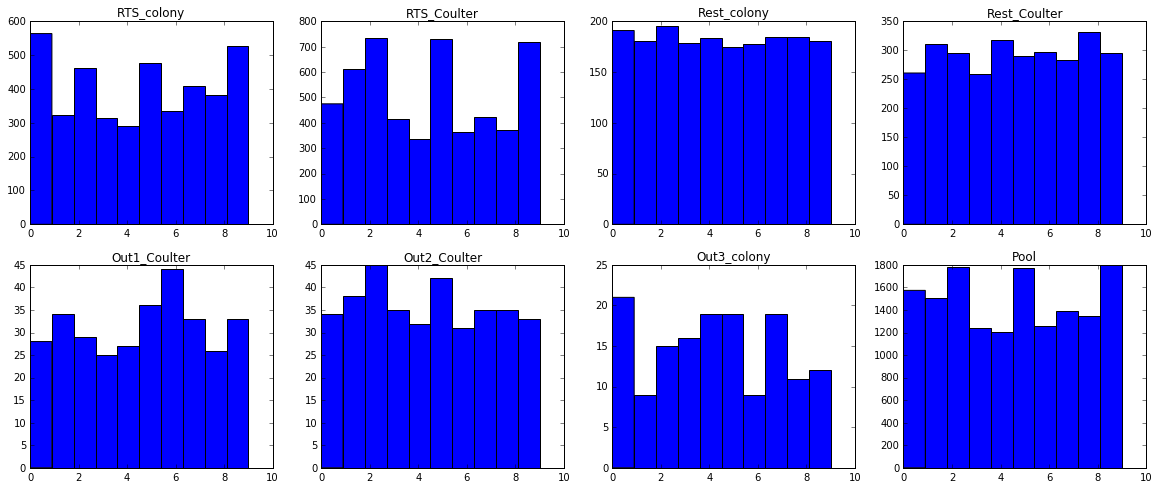

In [76]:
# In this section we plot the distribution of last digit for RTS, Rest and All of them pooled together for the Coulter
# Data. We ignore the NAN values

# Compute the last digit distribution
rld = compute_last_digit(rts_coulter_df.values)
rc_ld = compute_last_digit(rts_colony_df.values)
rest_ld = compute_last_digit(rest_coulter_df.values[:,0:3])
restc_ld = compute_last_digit(rest_colony_df.values[:,1:4])
out1_ld = compute_last_digit(out1_coulter_df.values)
out2_ld = compute_last_digit(out2_coulter_df.values)
out3_ld = compute_last_digit(out3_colony_df.values)
pool_ld = np.concatenate([rld, rc_ld, rest_ld, restc_ld, out1_ld, out2_ld, out3_ld])

# Now Plot
plt.figure(figsize=[20,8])
plt.subplot(241)
plot_np_hist(rc_ld, 'RTS_colony')
plt.subplot(242)
plot_np_hist(rld, 'RTS_Coulter')
plt.subplot(243)
plot_np_hist(restc_ld, 'Rest_colony')
plt.subplot(244)
plot_np_hist(rest_ld, 'Rest_Coulter')
plt.subplot(245)
plot_np_hist(out1_ld, 'Out1_Coulter')
plt.subplot(246)
plot_np_hist(out2_ld, 'Out2_Coulter')
plt.subplot(247)
plot_np_hist(out3_ld, 'Out3_colony')
plt.subplot(248)
plot_np_hist(pool_ld, 'Pool')

plt.show()

In [78]:
#ChiSquare test to match frequencies wrt terminal digits.
#DELETEME Is this OK using scipy.stats.chisquare or is it better to do it manually (see python files)?
#altenatively build
#chi_val = 0
#for f in freq:
#    chi_val = chi_val + ( (f - exp_freq) ** 2) / exp_freq
#p_val = sp.stats.chisqprob(chi_val, DF)

#build convenience dictionaries
names = ('RTS_Coulter', 'RTS_Colony', 'Rest_Coulter', 'Rest_Colony', 'Out1_Coulter', 'Out2_Coulter', 'Out3_Colony')
data = (rld, rc_ld, rest_ld, restc_ld, out1_ld, out2_ld, out3_ld)

datamap = {name: d for (name, d) in zip(names, data)}
exp_freq_ld = dict.fromkeys(names, None)
hist_ld = dict.fromkeys(names, None)
chi2_ld = dict.fromkeys(names, None)


for name in names:
    #Expected frequencies
    exp_freq_ld[name] = np.array([len(datamap[name])/10 for _ in range(10)])
    
    #build frequencies histograms for each group
    hist_ld[name] = np.histogram(datamap[name], range(10 + 1))
    
    #perform chi-square test
    chi2_ld[name] = stats.chisquare(hist_ld[name][0], exp_freq_ld[name])
    

#table 3 results
print('Digit -> \t 0 \t 1 \t 2 \t 3 \t 4 \t 5 \t 6 \t 7 \t 8 \t 9')
print('Name \t\t\t\t\t\t\t\t\t\t\t  \t total \t chi-square \t P \t')

for name in names:
    print('%s \t %s \t %d \t %0.4f \t %0.4f' % (name,
                                          ' \t '.join(map(str, hist_ld[name][0])), 
                                          sum(hist_ld[name][0]), chi2_ld[name][0], 
                                          chi2_ld[name][1]))

Digit -> 	 0 	 1 	 2 	 3 	 4 	 5 	 6 	 7 	 8 	 9
Name 											  	 total 	 chi-square 	 P 	
RTS_Coulter 	 475 	 613 	 736 	 416 	 335 	 732 	 363 	 425 	 372 	 718 	 5185 	 467.3301 	 0.0000
RTS_Colony 	 564 	 324 	 463 	 313 	 290 	 478 	 336 	 408 	 383 	 526 	 4085 	 200.9779 	 0.0000
Rest_Coulter 	 261 	 311 	 295 	 259 	 318 	 290 	 298 	 283 	 331 	 296 	 2942 	 16.0068 	 0.0667
Rest_Colony 	 191 	 181 	 195 	 179 	 184 	 175 	 178 	 185 	 185 	 181 	 1834 	 1.8033 	 0.9942
Out1_Coulter 	 28 	 34 	 29 	 25 	 27 	 36 	 44 	 33 	 26 	 33 	 315 	 9.7097 	 0.3745
Out2_Coulter 	 34 	 38 	 45 	 35 	 32 	 42 	 31 	 35 	 35 	 33 	 360 	 4.9444 	 0.8391
Out3_Colony 	 21 	 9 	 15 	 16 	 19 	 19 	 9 	 19 	 11 	 12 	 150 	 12.1333 	 0.2059


### Comment
Rest_Colony seems having a suspiciously high P-value.
The next section will decompose that value wrt single individuals taking samples

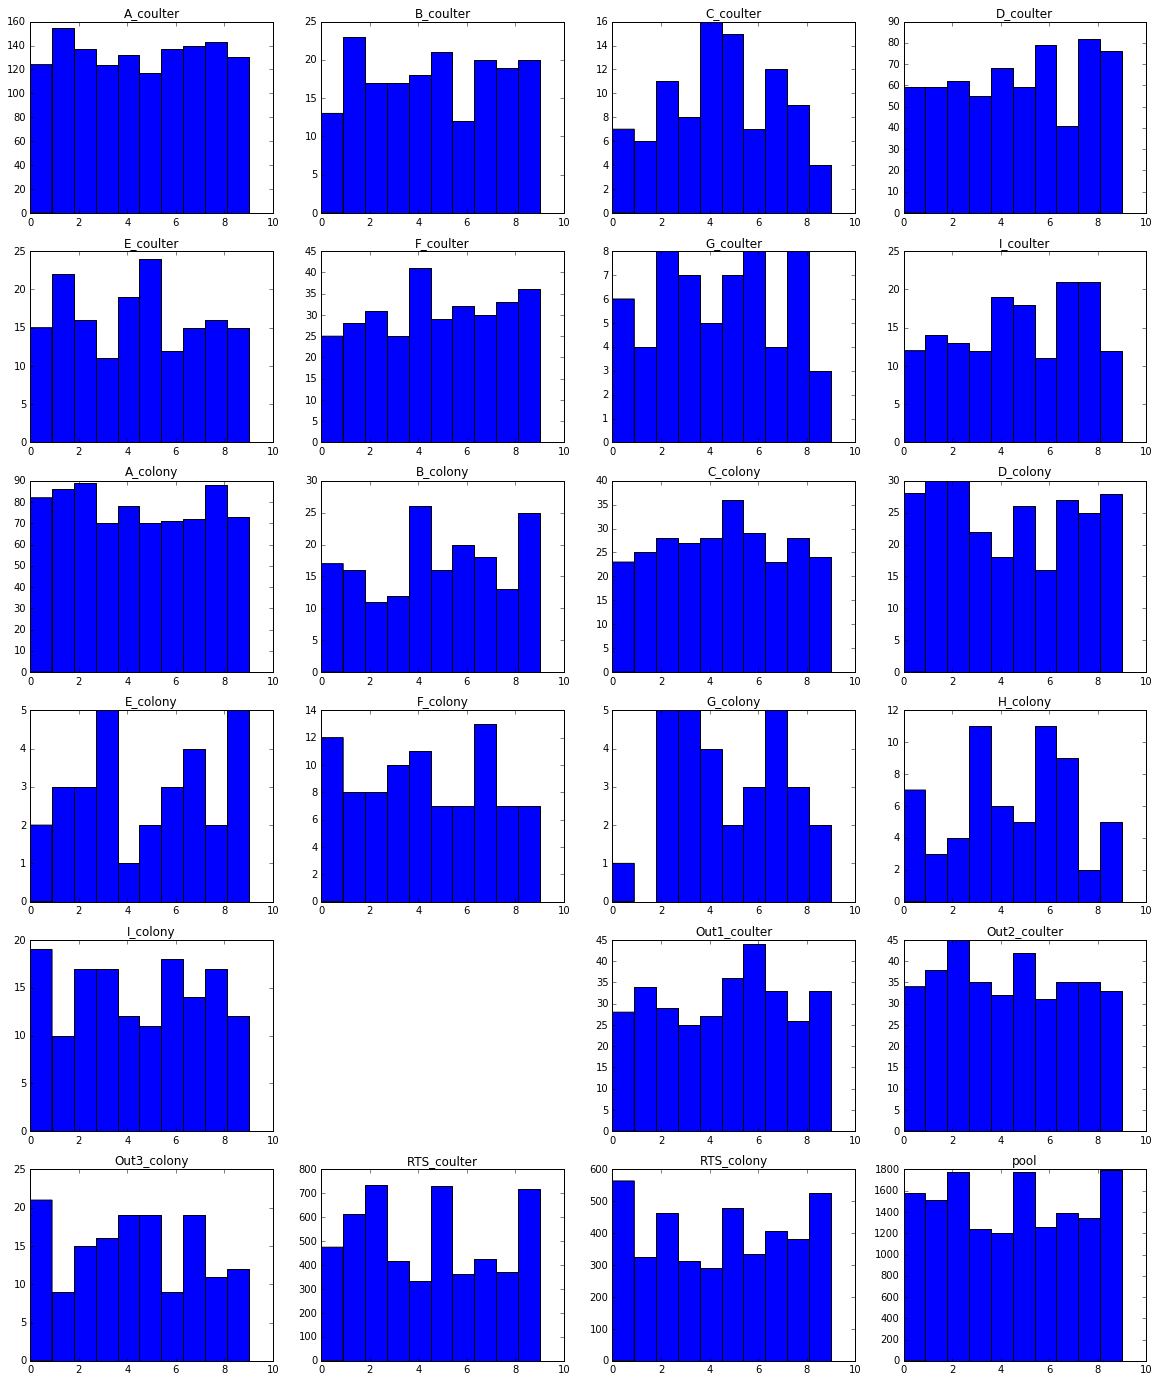

In [79]:
# Terminal digit plots decomposing labmates, 0 to 9, plus outside labs
def cld_val(df):
    return compute_last_digit(df.values[:,0:3])

def cldc_val(df):
    return compute_last_digit(df.values[:,1:4])

rest_grouped_ld = rest_coulter_df.groupby("Investigator").apply(cld_val)

restc_grouped_ld = rest_colony_df.groupby("Inv").apply(cldc_val)

plt.figure(figsize = [20,24])
for j in range(rest_grouped_ld.shape[0]):
    plt.subplot(6,4,j+1)
    plot_np_hist(rest_grouped_ld[j], '%s_coulter' % rest_grouped_ld.index[j])
    
for t in range(restc_grouped_ld.shape[0]):
    plt.subplot(6,4,t+j+2)
    plot_np_hist(restc_grouped_ld[t], '%s_colony' % restc_grouped_ld.index[t])
    

plt.subplot(6,4,19)
plot_np_hist(out1_ld, 'Out1_coulter')
plt.subplot(6,4,20)
plot_np_hist(out2_ld, 'Out2_coulter')
plt.subplot(6,4,21)
plot_np_hist(out3_ld, 'Out3_colony')
plt.subplot(6,4,22)
plot_np_hist(rld, 'RTS_coulter')
plt.subplot(6,4,23)
plot_np_hist(rc_ld, 'RTS_colony')
plt.subplot(6,4,24)
plot_np_hist(pool_ld, 'pool')
plt.show()

In [80]:
#ChiSquare test to match frequencies wrt terminal digits for individual lab partners

#Expected frequencies
ind_coulter_exp_freq = {}
ind_coulter_hist = {}
ind_coulter_chi2 = {}

ind_colony_exp_freq = {}
ind_colony_hist = {}
ind_colony_chi2 = {}

for j in range(rest_grouped_ld.shape[0]):
    ind_coulter_exp_freq[rest_grouped_ld.index[j]] = np.array([len(rest_grouped_ld[j])/10 for _ in range(10)])
    ind_coulter_hist[rest_grouped_ld.index[j]] = np.histogram(rest_grouped_ld[j], range(10 + 1))
    ind_coulter_chi2[rest_grouped_ld.index[j]] = stats.chisquare(ind_coulter_hist[rest_grouped_ld.index[j]][0], ind_coulter_exp_freq[rest_grouped_ld.index[j]])
    
for j in range(restc_grouped_ld.shape[0]):
    ind_colony_exp_freq[restc_grouped_ld.index[j]] = np.array([len(restc_grouped_ld[j])/10 for _ in range(10)])
    ind_colony_hist[restc_grouped_ld.index[j]] = np.histogram(restc_grouped_ld[j], range(10 + 1))
    ind_colony_chi2[restc_grouped_ld.index[j]] = stats.chisquare(ind_colony_hist[restc_grouped_ld.index[j]][0], ind_colony_exp_freq[restc_grouped_ld.index[j]])
    

#table 3 results
print('Coulter Counts:')
print('Digit -> 0 \t 1 \t 2 \t 3 \t 4 \t 5 \t 6 \t 7 \t 8 \t 9')
print('Name(i) \t\t\t\t\t\t\t\t\t\t No. \t Chi-square \t P \t')

for j in range(rest_grouped_ld.shape[0]):
    print('%s \t %s \t %d \t %0.4f \t %0.4f' % (rest_grouped_ld.index[j],
                                                  ' \t '.join(map(str, ind_coulter_hist[rest_grouped_ld.index[j]][0])), 
                                                  sum(ind_coulter_hist[rest_grouped_ld.index[j]][0]), 
                                                  ind_coulter_chi2[rest_grouped_ld.index[j]][0], 
                                                  ind_coulter_chi2[rest_grouped_ld.index[j]][1]))
    
print('Colony Counts:')
print('Digit -> 0 \t 1 \t 2 \t 3 \t 4 \t 5 \t 6 \t 7 \t 8 \t 9')
print('Name(i) \t\t\t\t\t\t\t\t\t\t No. \t Chi-square \t P \t')
for j in range(restc_grouped_ld.shape[0]):
    print('%s \t %s \t %d \t %0.4f \t %0.4f' % (restc_grouped_ld.index[j],
                                                  ' \t '.join(map(str, ind_colony_hist[restc_grouped_ld.index[j]][0])), 
                                                  sum(ind_colony_hist[restc_grouped_ld.index[j]][0]), 
                                                  ind_colony_chi2[restc_grouped_ld.index[j]][0], 
                                                  ind_colony_chi2[restc_grouped_ld.index[j]][1]))

Coulter Counts:
Digit -> 0 	 1 	 2 	 3 	 4 	 5 	 6 	 7 	 8 	 9
Name(i) 										 No. 	 Chi-square 	 P 	
A 	 124 	 155 	 137 	 124 	 132 	 117 	 137 	 140 	 143 	 130 	 1339 	 8.2180 	 0.5123
B 	 13 	 23 	 17 	 17 	 18 	 21 	 12 	 20 	 19 	 20 	 180 	 5.8889 	 0.7510
C 	 7 	 6 	 11 	 8 	 16 	 15 	 7 	 12 	 9 	 4 	 95 	 15.6667 	 0.0742
D 	 59 	 59 	 62 	 55 	 68 	 59 	 79 	 41 	 82 	 76 	 640 	 21.8438 	 0.0094
E 	 15 	 22 	 16 	 11 	 19 	 24 	 12 	 15 	 16 	 15 	 165 	 9.5625 	 0.3870
F 	 25 	 28 	 31 	 25 	 41 	 29 	 32 	 30 	 33 	 36 	 310 	 6.9677 	 0.6405
G 	 6 	 4 	 8 	 7 	 5 	 7 	 8 	 4 	 8 	 3 	 60 	 5.3333 	 0.8043
I 	 12 	 14 	 13 	 12 	 19 	 18 	 11 	 21 	 21 	 12 	 153 	 9.6667 	 0.3781
Colony Counts:
Digit -> 0 	 1 	 2 	 3 	 4 	 5 	 6 	 7 	 8 	 9
Name(i) 										 No. 	 Chi-square 	 P 	
A 	 82 	 86 	 89 	 70 	 78 	 70 	 71 	 72 	 88 	 73 	 779 	 7.1039 	 0.6263
B 	 17 	 16 	 11 	 12 	 26 	 16 	 20 	 18 	 13 	 25 	 174 	 13.7647 	 0.1309
C 	 23 	 25 	 28 	 27 	 28 	 36 	 2

### Comment
Decomposing data for other investigators shows that the single p-values are less suspiciuos than the p-value of the aggregate data.

## Permutation tests for terminal digits

In [81]:
# Coulter - Std dev
# In this section, Difference between Std Dev is the Test Statistics
#rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(cld_val)
#rn = np.asarray(rr)
#pval, tstat, statmc = exact_mc_perm_test(rld, rest_ld, nmc)
#std_stat = {}
#fig = plt.figure(figsize = [16,5])
#for j in range(rr.shape[0]):
#    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
#    ys = np.hstack([ys,rld])
#    xs = rn[j]
#    std_stat[j] = exact_mc_perm_test(xs, ys, nmc)
#    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
#    ax = fig.add_subplot(2,5,j+1)
#    pretty_plots(ax, std_stat[j][2], rr.index[j])
#    plt.axvline(std_stat[j][1], color='r')
#ax = fig.add_subplot(2,5,10)
#pretty_plots(ax, statmc, 'RTS')
#plt.axvline(tstat, color='r')
#print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
#plt.show()
#std_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.000000, test-statistic = 0.213431
For B, p-value = 0.444000, test-statistic = 0.184041
For C, p-value = 0.031000, test-statistic = 0.413490
For D, p-value = 0.000000, test-statistic = 0.252339
For E, p-value = 0.489000, test-statistic = 0.184958
For F, p-value = 0.021000, test-statistic = 0.221252
For G, p-value = 0.484000, test-statistic = 0.305207
For I, p-value = 0.032000, test-statistic = 0.296299
For RTS, p-value = 0.000000, test-statistic = 0.275110


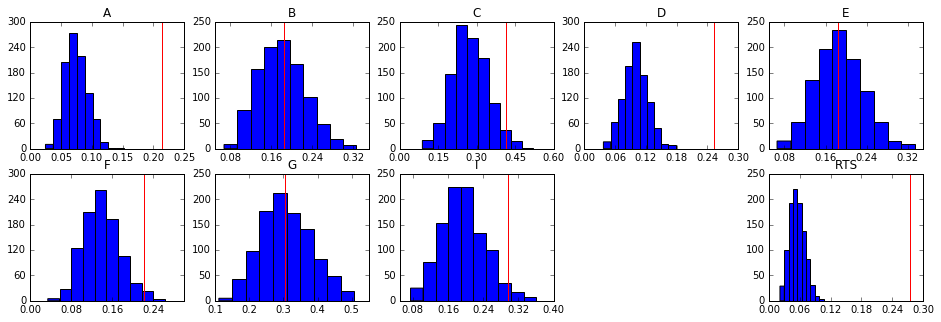

In [82]:
# Coulter - Density
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(cld_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(rld, rest_ld, nmc, density_distance)
den_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,rld])
    xs = rn[j]
    den_stat[j] = exact_mc_perm_test(xs, ys, nmc, density_distance)
    print("For %s, p-value = %f, test-statistic = %f" % (rr.index[j], den_stat[j][0], den_stat[j][1]))
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, den_stat[j][2], rr.index[j])
    plt.axvline(den_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
den_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.120000, test-statistic = 0.146983
For B, p-value = 0.771000, test-statistic = 0.151557
For C, p-value = 0.114000, test-statistic = 0.567684
For D, p-value = 0.016000, test-statistic = 0.281051
For E, p-value = 0.664000, test-statistic = 0.179249
For F, p-value = 0.162000, test-statistic = 0.258380
For G, p-value = 0.805000, test-statistic = 0.245248
For I, p-value = 0.113000, test-statistic = 0.393264
For RTS, p-value = 0.000000, test-statistic = 0.236771


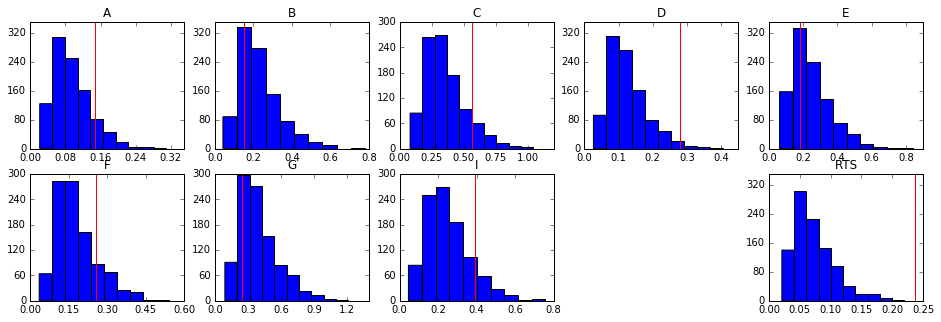

In [83]:
# Coulter - CDF
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(cld_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(rld, rest_ld, nmc, cdf_distance)
cdf_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,rld])
    xs = rn[j]
    cdf_stat[j] = exact_mc_perm_test(xs, ys, nmc, cdf_distance)
    print("For %s, p-value = %f, test-statistic = %f" % (rr.index[j], cdf_stat[j][0], cdf_stat[j][1]))
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, cdf_stat[j][2], rr.index[j])
    plt.axvline(cdf_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
cdf_stat['RTS']=pval, tstat, statmc

In [84]:
# Colony - Std dev
# In this section, Difference between Std Dev is the Test Statistics
#rr = rest_colony_df.dropna(axis=0).groupby("Inv").apply(cldc_val)
#rn = np.asarray(rr)
#pval, tstat, statmc = exact_mc_perm_test(rc_ld, restc_ld, nmc)
#std_stat = {}
#fig = plt.figure(figsize = [16,5])
#for j in range(rr.shape[0]):
#    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
#    ys = np.hstack([ys,rc_ld])
#    xs = rn[j]
#    std_stat[j] = exact_mc_perm_test(xs, ys, nmc)
#    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
#    ax = fig.add_subplot(2,5,j+1)
#    pretty_plots(ax, std_stat[j][2], rr.index[j])
#    plt.axvline(std_stat[j][1], color='r')
#ax = fig.add_subplot(2,5,10)
#pretty_plots(ax, statmc, 'RTS')
#plt.axvline(tstat, color='r')
#print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
#plt.show()
#std_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.001000, test-statistic = 0.173796
For B, p-value = 0.036000, test-statistic = 0.271435
For C, p-value = 0.057000, test-statistic = 0.214758
For D, p-value = 0.663000, test-statistic = 0.137272
For E, p-value = 0.660000, test-statistic = 0.384650
For F, p-value = 0.388000, test-statistic = 0.272824
For G, p-value = 0.129000, test-statistic = 0.556164
For H, p-value = 0.016000, test-statistic = 0.480985
For I, p-value = 0.318000, test-statistic = 0.231840
For RTS, p-value = 0.000000, test-statistic = 0.185209


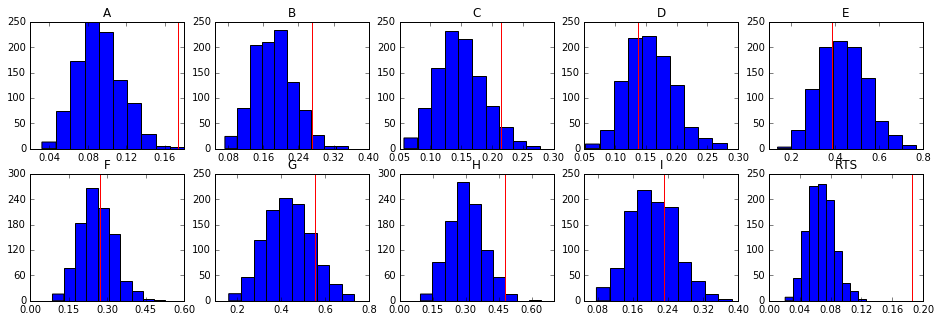

In [85]:
# Colony - density
# In this section, Difference between Std Dev is the Test Statistics
rr_c = rest_colony_df.dropna(axis=0).groupby("Inv").apply(cldc_val)
rn_c = np.asarray(rr_c)
pval, tstat, statmc = exact_mc_perm_test(rc_ld, restc_ld, nmc, density_distance)
den_stat_c = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr_c.shape[0]):
    ys = np.hstack([rn_c[t] for t in range(rn_c.shape[0]) if t!=j])
    ys = np.hstack([ys,rc_ld])
    xs = rn_c[j]
    den_stat_c[j] = exact_mc_perm_test(xs, ys, nmc, density_distance)
    print("For %s, p-value = %f, test-statistic = %f" % (rr_c.index[j], den_stat_c[j][0], den_stat_c[j][1]))
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, den_stat_c[j][2], rr_c.index[j])
    plt.axvline(den_stat_c[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
den_stat_c['RTS']=pval, tstat, statmc

For A, p-value = 0.152000, test-statistic = 0.178792
For B, p-value = 0.234000, test-statistic = 0.301562
For C, p-value = 0.136000, test-statistic = 0.288880
For D, p-value = 0.543000, test-statistic = 0.172211
For E, p-value = 0.710000, test-statistic = 0.392097
For F, p-value = 0.607000, test-statistic = 0.263347
For G, p-value = 0.345000, test-statistic = 0.605782
For H, p-value = 0.318000, test-statistic = 0.425595
For I, p-value = 0.813000, test-statistic = 0.163037
For RTS, p-value = 0.037000, test-statistic = 0.181517


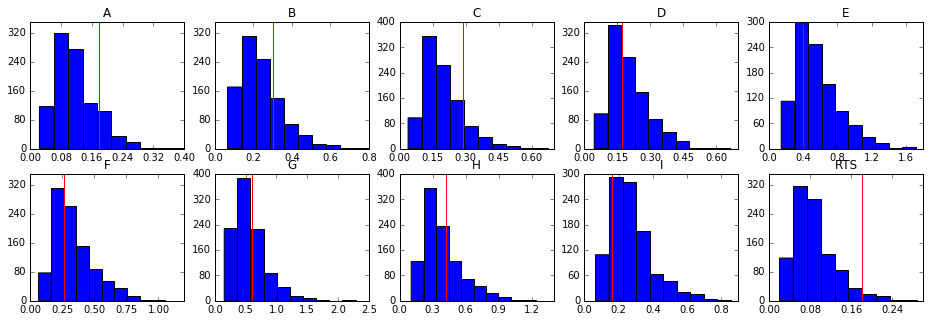

In [86]:
# Colony - cdf
# In this section, Difference between Std Dev is the Test Statistics
rr_c = rest_colony_df.dropna(axis=0).groupby("Inv").apply(cldc_val)
rn_c = np.asarray(rr_c)
pval, tstat, statmc = exact_mc_perm_test(rc_ld, restc_ld, nmc, cdf_distance)
cdf_stat_c = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr_c.shape[0]):
    ys = np.hstack([rn_c[t] for t in range(rn_c.shape[0]) if t!=j])
    ys = np.hstack([ys,rc_ld])
    xs = rn_c[j]
    cdf_stat_c[j] = exact_mc_perm_test(xs, ys, nmc, cdf_distance)
    print("For %s, p-value = %f, test-statistic = %f" % (rr_c.index[j], cdf_stat_c[j][0], cdf_stat_c[j][1]))
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, cdf_stat_c[j][2], rr_c.index[j])
    plt.axvline(cdf_stat_c[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
cdf_stat_c['RTS']=pval, tstat, statmc

In [87]:
# print all p-values

print('Coulter Counts')
print('Test Stat -> \t Density \t CDF  \t')
print('Name(i)  No.')
for j in range(rr.shape[0]):
    print('%s \t %i \t %0.4f \t %0.4f' % (rr.index[j], rn[j].shape[0], den_stat[j][0], cdf_stat[j][0]))
print('RTS \t %i \t %0.4f \t %0.4f'% (len(rld), den_stat['RTS'][0], cdf_stat['RTS'][0]))
print('')
print('Colony Counts')
print('Test Stat -> \t Density \t CDF  \t')
print('Name(i)  No.')
for j in range(rr_c.shape[0]):
    print('%s \t %i \t %0.4f \t %0.4f' % (rr_c.index[j], rn_c[j].shape[0], den_stat_c[j][0], cdf_stat_c[j][0]))
print('RTS \t %i \t %0.4f \t %0.4f'% (len(rc_ld), den_stat_c['RTS'][0], cdf_stat_c['RTS'][0]))

Coulter Counts
Test Stat -> 	 Density 	 CDF  	
Name(i)  No.
A 	 1215 	 0.0000 	 0.1200
B 	 180 	 0.4440 	 0.7710
C 	 75 	 0.0310 	 0.1140
D 	 633 	 0.0000 	 0.0160
E 	 165 	 0.4890 	 0.6640
F 	 306 	 0.0210 	 0.1620
G 	 60 	 0.4840 	 0.8050
I 	 153 	 0.0320 	 0.1130
RTS 	 5185 	 0.0000 	 0.0000

Colony Counts
Test Stat -> 	 Density 	 CDF  	
Name(i)  No.
A 	 765 	 0.0010 	 0.1520
B 	 174 	 0.0360 	 0.2340
C 	 267 	 0.0570 	 0.1360
D 	 240 	 0.6630 	 0.5430
E 	 30 	 0.6600 	 0.7100
F 	 87 	 0.3880 	 0.6070
G 	 30 	 0.1290 	 0.3450
H 	 63 	 0.0160 	 0.3180
I 	 135 	 0.3180 	 0.8130
RTS 	 4085 	 0.0000 	 0.0370


# Equal digits test

In this case the three colony counts are considered independent
extrations.
The hypotesis is that the last pair of digits being equal
(for experiments with at least three digits)
behaves as a draw from a uniform distribution, that is, 10% chance

In [88]:
#build convenience dictionaries

dfs = (rts_coulter_df, rts_colony_df, rest_coulter_df, rest_colony_df, out1_coulter_df, out2_coulter_df, out3_colony_df)
dfmap = {name:df.values for (name,df) in zip(names, dfs)}
dfmap['Rest_Coulter'] = rest_coulter_df.values[:,0:3]
dfmap['Rest_Colony'] = rest_colony_df.values[:,1:4]

td_strings = dict.fromkeys(names, None)
td_binary = dict.fromkeys(names, None)
td_exp_freq = dict.fromkeys(names, None)
td_hist = dict.fromkeys(names, None)
td_chi2 = dict.fromkeys(names, None)

In [90]:
#retrieve data about last two digits

for name in names:
    #compute last two digits in string format
    td_strings[name] = compute_last_two_digits(dfmap[name])
    
    #compute 0-1 list
    td_binary[name] = compute_last_two_digits_binary(td_strings[name])

#print to check format
print(td_strings.values()[0][0:10])

#print to check format
print(td_binary.values()[0][0:10])

['47', '64', '58', '15', '09', '46', '55', '78', '12', '05']
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [91]:
#build freq expectations, histograms and chi-square tests
#we have only two sets, the terminal digits are the same, or not

for name in names:
    #expected frequencies: 0.9*length zeros, and 0.1*length ones
    td_exp_freq[name] = [len(td_binary[name])*0.9, len(td_binary[name])*0.1]
    
    #histograms
    td_hist[name] = np.histogram(td_binary[name], range(2 + 1))
    
    #chi-square
    td_chi2[name] = stats.chisquare(td_hist[name][0], td_exp_freq[name])

In [92]:
#print table

print('Name \t\t equal digits \t total \t ratio \t\t chi-square \t P \t')

for name in names:
    print('%s \t %d \t\t %d \t %g \t %g \t %g' % (name,
                                                sum(td_binary[name]),
                                                len(td_binary[name]),
                                                1.*sum(td_binary[name])/len(td_binary[name]),
                                                td_chi2[name][0],
                                                td_chi2[name][1]))

Name 		 equal digits 	 total 	 ratio 		 chi-square 	 P 	
RTS_Coulter 	 644 		 5184 	 0.124228 	 33.8121 	 6.0701e-09
RTS_Colony 	 135 		 1660 	 0.0813253 	 6.4324 	 0.0112057
Rest_Coulter 	 286 		 2887 	 0.0990648 	 0.0280568 	 0.866975
Rest_Colony 	 53 		 507 	 0.104536 	 0.115933 	 0.733489
Out1_Coulter 	 32 		 306 	 0.104575 	 0.0711692 	 0.789642
Out2_Coulter 	 30 		 360 	 0.0833333 	 1.11111 	 0.291841
Out3_Colony 	 1 		 7 	 0.142857 	 0.142857 	 0.705457


### Comment
As for the terminal digits, the combined labmates P-value seems a bit high.
The next section analyzes single investigator data

In [93]:
# Equal digits decomposing labmates, 0 to 9
def td_cld_val(df):
    return compute_last_two_digits_binary(compute_last_two_digits(df.values[:,0:3]))

def td_cldc_val(df):
    return compute_last_two_digits_binary(compute_last_two_digits(df.values[:,1:4]))

rest_grouped_td = rest_coulter_df.groupby("Investigator").apply(td_cld_val)
restc_grouped_td = rest_colony_df.groupby("Inv").apply(td_cldc_val)

#filter out empty groups
empty = []
for j in range(rest_grouped_td.shape[0]):
    if len(rest_grouped_td[j])==0:
        empty.append(j)
        
for e in empty:
    print("Investigator %s has no coulter samples with more than 3 digits" % rest_grouped_td.index[e])
    rest_grouped_td = rest_grouped_td.drop(rest_grouped_td.index[e])
    
emptyc = []
for j in range(restc_grouped_td.shape[0]):
    if len(restc_grouped_td[j])==0:
        emptyc.append(j)
        
for e in emptyc:
    print("Investigator %s has no colony samples with more than 3 digits" % restc_grouped_td.index[e])
    restc_grouped_td = restc_grouped_td.drop(restc_grouped_td.index[e])


Investigator G has no colony samples with more than 3 digits


In [94]:
#ChiSquare test to match frequencies wrt terminal digits for individual lab partners

#Expected frequencies
td_ind_coulter_exp_freq = {}
td_ind_coulter_hist = {}
td_ind_coulter_chi2 = {}

td_ind_colony_exp_freq = {}
td_ind_colony_hist = {}
td_ind_colony_chi2 = {}

for j in range(rest_grouped_td.shape[0]):
    td_ind_coulter_exp_freq[rest_grouped_td.index[j]] = np.array([len(rest_grouped_td[j])*0.9, len(rest_grouped_td[j])*0.1])
    td_ind_coulter_hist[rest_grouped_td.index[j]] = np.histogram(rest_grouped_td[j], range(2 + 1))
    td_ind_coulter_chi2[rest_grouped_td.index[j]] = stats.chisquare(td_ind_coulter_hist[rest_grouped_td.index[j]][0], td_ind_coulter_exp_freq[rest_grouped_td.index[j]])
    
for j in range(restc_grouped_td.shape[0]):
    td_ind_colony_exp_freq[restc_grouped_td.index[j]] = np.array([len(restc_grouped_td[j])*0.9, len(restc_grouped_td[j])*0.1])
    td_ind_colony_hist[restc_grouped_td.index[j]] = np.histogram(restc_grouped_td[j], range(2 + 1))
    td_ind_colony_chi2[restc_grouped_td.index[j]] = stats.chisquare(td_ind_colony_hist[restc_grouped_td.index[j]][0], td_ind_colony_exp_freq[restc_grouped_td.index[j]])
     

#table results
print('Coulter Counts:')
print('Name(i)\t Eq. digits \t No. \t Ratio \t\t Chi-square \t P \t')

for j in range(rest_grouped_td.shape[0]):
    print('%s \t %d \t\t %d \t %0.4f \t %0.4f \t %0.4f' % (rest_grouped_td.index[j],
                                                sum(rest_grouped_td[j]),
                                                len(rest_grouped_td[j]),
                                                1.*sum(rest_grouped_td[j])/len(rest_grouped_td[j]),
                                                td_ind_coulter_chi2[rest_grouped_td.index[j]][0],
                                                td_ind_coulter_chi2[rest_grouped_td.index[j]][1]))
#print restc_grouped_td

print('Colony Counts:')
print('Name(i)\t Eq. digits \t No. \t Ratio \t\t Chi-square \t P \t')
for j in range(restc_grouped_td.shape[0]):
    print('%s \t %d \t\t %d \t %0.4f \t %0.4f \t %0.4f' % (restc_grouped_td.index[j],
                                                sum(restc_grouped_td[j]),
                                                len(restc_grouped_td[j]),
                                                1.*sum(restc_grouped_td[j])/len(restc_grouped_td[j]),
                                                td_ind_colony_chi2[restc_grouped_td.index[j]][0],
                                                td_ind_colony_chi2[restc_grouped_td.index[j]][1]))

Coulter Counts:
Name(i)	 Eq. digits 	 No. 	 Ratio 		 Chi-square 	 P 	
A 	 132 		 1318 	 0.1002 	 0.0003 	 0.9853
B 	 16 		 180 	 0.0889 	 0.2469 	 0.6193
C 	 8 		 95 	 0.0842 	 0.2632 	 0.6080
D 	 62 		 638 	 0.0972 	 0.0564 	 0.8122
E 	 13 		 134 	 0.0970 	 0.0133 	 0.9083
F 	 40 		 309 	 0.1294 	 2.9777 	 0.0844
G 	 4 		 60 	 0.0667 	 0.7407 	 0.3894
I 	 11 		 153 	 0.0719 	 1.3428 	 0.2465
Colony Counts:
Name(i)	 Eq. digits 	 No. 	 Ratio 		 Chi-square 	 P 	
A 	 28 		 263 	 0.1065 	 0.1221 	 0.7268
B 	 4 		 48 	 0.0833 	 0.1481 	 0.7003
C 	 1 		 28 	 0.0357 	 1.2857 	 0.2568
D 	 7 		 41 	 0.1707 	 2.2791 	 0.1311
E 	 1 		 16 	 0.0625 	 0.2500 	 0.6171
F 	 2 		 31 	 0.0645 	 0.4337 	 0.5102
H 	 4 		 33 	 0.1212 	 0.1650 	 0.6846
I 	 6 		 47 	 0.1277 	 0.3995 	 0.5273


In [95]:
# Permutation tests

# Coulter - Std dev
# In this section, Difference between Std Dev is the Test Statistics
#rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(td_cld_val)
#rn = np.asarray(rr)
#pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Coulter'], td_binary['Rest_Coulter'], nmc)
#std_stat = {}
#fig = plt.figure(figsize = [16,5])
#for j in range(rr.shape[0]):
#    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
#    ys = np.hstack([ys,td_binary['RTS_Coulter']])
#    xs = rn[j]
#    std_stat[j] = exact_mc_perm_test(xs, ys, nmc)
#    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
#    ax = fig.add_subplot(2,5,j+1)
#    pretty_plots(ax, std_stat[j][2], rr.index[j])
#    plt.axvline(std_stat[j][1], color='r')
#ax = fig.add_subplot(2,5,10)
#pretty_plots(ax, statmc, 'RTS')
#plt.axvline(tstat, color='r')
#print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
#plt.show()
#std_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.077000, test-statistic = 0.032479
For B, p-value = 0.251000, test-statistic = 0.055418
For C, p-value = 0.275000, test-statistic = 0.072623
For D, p-value = 0.136000, test-statistic = 0.038490
For E, p-value = 0.437000, test-statistic = 0.038558
For F, p-value = 0.376000, test-statistic = 0.031576
For G, p-value = 0.220000, test-statistic = 0.099355
For I, p-value = 0.070000, test-statistic = 0.089882
For RTS, p-value = 0.000000, test-statistic = 0.050327


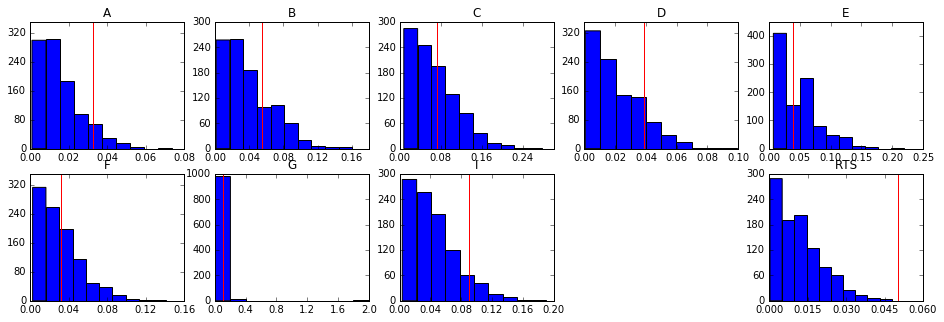

In [96]:
# Coulter - Density
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(td_cld_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Coulter'], td_binary['Rest_Coulter'], nmc, density_distance)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,td_binary['RTS_Coulter']])
    xs = rn[j]
    std_stat[j] = exact_mc_perm_test(xs, ys, nmc, density_distance)
    print("For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1]))
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, std_stat[j][2], rr.index[j])
    plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
std_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.090000, test-statistic = 0.146156
For B, p-value = 0.237000, test-statistic = 0.249380
For C, p-value = 0.275000, test-statistic = 0.326805
For D, p-value = 0.129000, test-statistic = 0.173205
For E, p-value = 0.414000, test-statistic = 0.173512
For F, p-value = 0.354000, test-statistic = 0.142094
For G, p-value = 0.218000, test-statistic = 0.447098
For I, p-value = 0.069000, test-statistic = 0.404468
For RTS, p-value = 0.001000, test-statistic = 0.226473


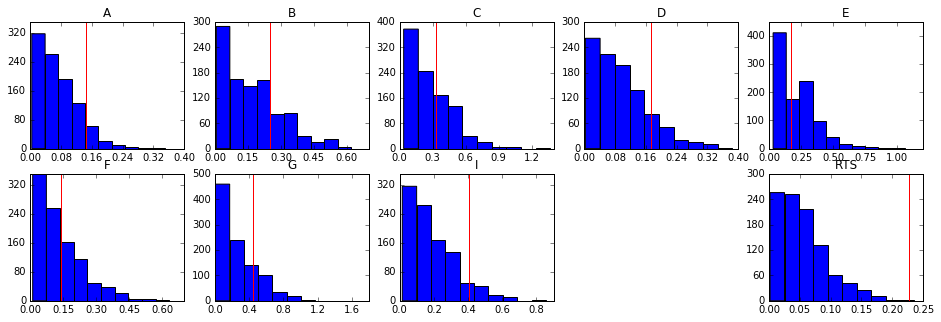

In [97]:
# Coulter - CDF
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(td_cld_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Coulter'], td_binary['Rest_Coulter'], nmc, cdf_distance)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,td_binary['RTS_Coulter']])
    xs = rn[j]
    std_stat[j] = exact_mc_perm_test(xs, ys, nmc, cdf_distance)
    print("For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1]))
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, std_stat[j][2], rr.index[j])
    plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
std_stat['RTS']=pval, tstat, statmc

In [98]:
# Colony - Std dev
# In this section, Difference between Std Dev is the Test Statistics
#rr = rest_colony_df.dropna(axis=0).groupby("Inv").apply(td_cldc_val)
#rn = np.asarray(rr)
#pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Colony'], td_binary['Rest_Colony'], nmc)
#std_stat = {}
#fig = plt.figure(figsize = [16,5])
#for j in range(rr.shape[0]):
#    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
#    ys = np.hstack([ys,td_binary['RTS_Colony']])
#    xs = rn[j]
#    
#    if len(xs) > 0:
#        std_stat[j] = exact_mc_perm_test(xs, ys, nmc)
#        print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
#        ax = fig.add_subplot(2,5,j+1)
#        pretty_plots(ax, std_stat[j][2], rr.index[j])
#        plt.axvline(std_stat[j][1], color='r')
#ax = fig.add_subplot(2,5,10)
#pretty_plots(ax, statmc, 'RTS')
#plt.axvline(tstat, color='r')
#print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
#plt.show()
#std_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.164000, test-statistic = 0.051621
For B, p-value = 0.777000, test-statistic = 0.007619
For C, p-value = 0.261000, test-statistic = 0.091808
For D, p-value = 0.072000, test-statistic = 0.128273
For E, p-value = 0.628000, test-statistic = 0.049484
For F, p-value = 0.512000, test-statistic = 0.036680
For H, p-value = 0.322000, test-statistic = 0.069375
For I, p-value = 0.155000, test-statistic = 0.107098
For RTS, p-value = 0.086000, test-statistic = 0.046422


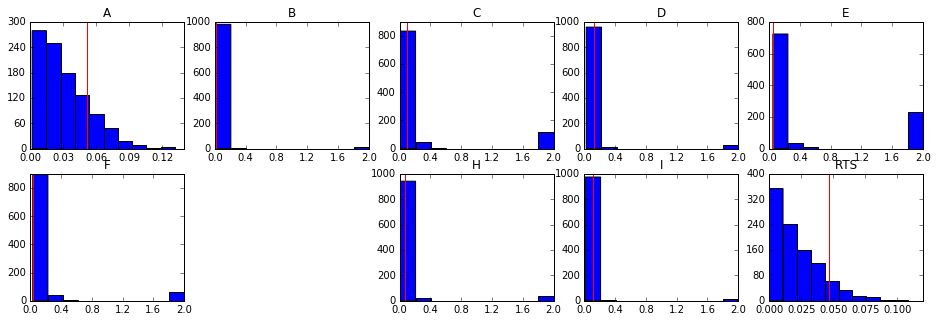

In [99]:
# Colony - density
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_colony_df.dropna(axis=0).groupby("Inv").apply(td_cldc_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Colony'], td_binary['Rest_Colony'], nmc, density_distance)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,td_binary['RTS_Colony']])
    xs = rn[j]
    
    if len(xs) > 0:
        std_stat[j] = exact_mc_perm_test(xs, ys, nmc, density_distance)
        print("For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1]))
        ax = fig.add_subplot(2,5,j+1)
        pretty_plots(ax, std_stat[j][2], rr.index[j])
        plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print ("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
std_stat['RTS']=pval, tstat, statmc

For A, p-value = 0.159000, test-statistic = 0.232292
For B, p-value = 0.785000, test-statistic = 0.034286
For C, p-value = 0.273000, test-statistic = 0.413136
For D, p-value = 0.082000, test-statistic = 0.577230
For E, p-value = 0.669000, test-statistic = 0.222678
For F, p-value = 0.496000, test-statistic = 0.165058
For H, p-value = 0.337000, test-statistic = 0.312186
For I, p-value = 0.168000, test-statistic = 0.481942
For RTS, p-value = 0.080000, test-statistic = 0.208901


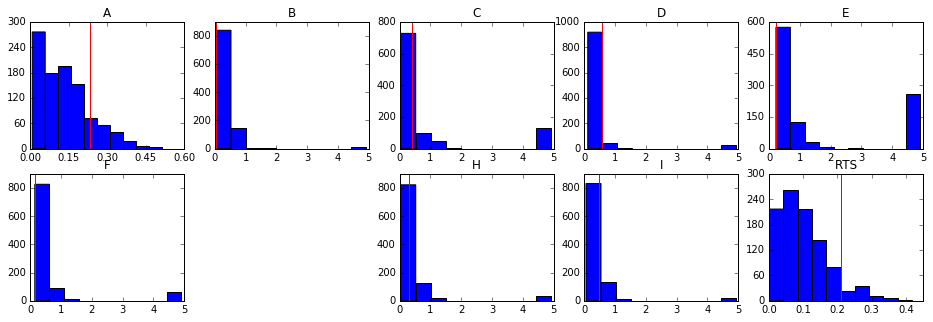

In [100]:
# Colony - density
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_colony_df.dropna(axis=0).groupby("Inv").apply(td_cldc_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Colony'], td_binary['Rest_Colony'], nmc, cdf_distance)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,td_binary['RTS_Colony']])
    xs = rn[j]
    
    if len(xs) > 0:
        std_stat[j] = exact_mc_perm_test(xs, ys, nmc, cdf_distance)
        print ("For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1]))
        ax = fig.add_subplot(2,5,j+1)
        pretty_plots(ax, std_stat[j][2], rr.index[j])
        plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print("For RTS, p-value = %f, test-statistic = %f" % (pval, tstat))
plt.show()
std_stat['RTS']=pval, tstat, statmc